## Module 3 Assignment ##

1. Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate (1) the all time record high and low and (2) the normal (mean) high and low temperature *FOR EACH CALENDAR DAY* for the 1991-2020 period for the desired station.  The function should return a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp'] FOR EACH DAY.  Write a code that can call this function and successfully demonstrate that it works.

In [1]:
# Some of these initial steps are me trying to figure out which station to use
# First working with the code  from M3N1 notebook to sort organize station data

import pandas as pd
# Import station ID data
stn_ids = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', header=None, infer_nrows=1000)
stn_ids.columns = ['ID','LAT','LON','ELEV','UKN','NAME','GSN','WBAN']
# Import station inventory file
periods = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt', header=None, infer_nrows=1000)
periods.columns = ['ID','LAT','LON','ELEM','TiMIN','TiMAX']
# And merge the two datasets along station ID column
merged_stns = pd.merge(stn_ids,periods,how='left',left_on='ID',right_on='ID')
merged_stns

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,TMAX,1949.0,1949.0
1,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,TMIN,1949.0,1949.0
2,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,PRCP,1949.0,1949.0
3,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,SNOW,1949.0,1949.0
4,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,SNWD,1949.0,1949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767089,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,67983.0,-20.2000,32.6160,PRCP,1951.0,2025.0
767090,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,67983.0,-20.2000,32.6160,TAVG,1962.0,2025.0
767091,ZI000067991,-22.2170,30.0000,457.0,NaN,BEITBRIDGE,NaN,67991.0,-22.2170,30.0000,TMAX,1951.0,1990.0
767092,ZI000067991,-22.2170,30.0000,457.0,NaN,BEITBRIDGE,NaN,67991.0,-22.2170,30.0000,TMIN,1951.0,1990.0


In [2]:
# Here I want to identify which stations have temp data (I am assuming that if they have TMAX they will also have TMIN...)
# I know the instructions specify the time period from 1991-2020. I decided to search for stations that have data through 2025.

merged_stns = merged_stns[(merged_stns['ELEM'] == 'TMAX') & (merged_stns['TiMAX'] == 2025)]

In [3]:
# Next I want to find which station IDs have data for Sacramento :)
# Based on whats printed below, I decided I am going to use ID USW00023232 (the ASOS station) for this assignment

merged_stns[merged_stns['NAME'].str.contains('SACRAMENTO', regex=False)]

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
744115,USW00023232,38.5067,-121.4961,5.8,CA,SACRAMENTO AP ASOS,NaN,72483.0,38.5067,-121.4961,TMAX,1941.0,2025.0
744567,USW00023271,38.5553,-121.4183,11.6,CA,SACRAMENTO 5 ESE,NaN,NaN,38.5553,-121.4183,TMAX,1877.0,2025.0
757275,USW00093225,38.7006,-121.5947,7.3,CA,SACRAMENTO METRO AP,NaN,NaN,38.7006,-121.5947,TMAX,1998.0,2025.0


In [4]:
# Now here is where I define my function for this question:
# Function inputs are the dataframe that will hold the data I pull from GHCN for my station of interest (df) and the station id (stnid)

def station_temp(stnid):

    # Read in dataset from GHCN for our chosen station
    df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/by_station/{stnid}.csv",
        storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
        dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
        parse_dates=['DATE']
        ).set_index('DATE')
    # Need to ensure the date column is saved as a datetime data type and set as the index
    df['DATE'] = pd.to_datetime(df.index)
    # Adding a column for day of year, so that later I can group by this value
    df['day_of_year'] = pd.to_datetime(df['DATE']).dt.dayofyear

    # Here I am subsetting the dataset to only include the years 1991-2020
    df_19912020 = df[(df.index >= pd.to_datetime('1991-01-01')) & (df.index <= pd.to_datetime('2020-12-31'))] 

    # Next taking another subset of the dataset to hold only TMAX values, and correcting units to be degrees C
    df_tmax = df_19912020.loc[df_19912020['ELEMENT'] == 'TMAX'].copy()
    df_tmax['daily_max'] = df_tmax['DATA_VALUE'] / 10

    # Same step for TMIN
    df_tmin = df_19912020.loc[df_19912020['ELEMENT'] == 'TMIN'].copy()
    df_tmin['daily_min'] = df_tmin['DATA_VALUE'] / 10

    # Now that we have isolated datasets for TMAX and TMIN, we can group by day of year, and calculate the record and average min and max for each day.
    df_tmax_per_day =  df_tmax.groupby('day_of_year')['daily_max'].agg(record_max_temp='max',average_max_temp='mean')
    df_tmin_per_day =  df_tmin.groupby('day_of_year')['daily_min'].agg(record_min_temp='min',average_min_temp='mean')

    # We created two dataframes that share the "day of year" column, so lets merge them to create the output 
    df_daily_temp = pd.merge(df_tmax_per_day, df_tmin_per_day, on='day_of_year')

    return df_daily_temp

In [5]:
# Define variables: 
stnid = 'USW00023271'

# and run function! yay!
station_temp(stnid)

/tmp/ipykernel_935/2534700291.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/by_station/{stnid}.csv",


,record_max_temp,average_max_temp,record_min_temp,average_min_temp
day_of_year,,,,
1,18.3,13.556667,-2.2,4.430000
2,18.9,13.093333,-1.0,4.353333
3,18.9,13.226667,-0.6,4.390000
4,18.9,13.543333,-1.1,4.736667
5,20.0,12.650000,-0.6,4.290000
...,...,...,...,...
362,20.0,13.346667,-0.6,4.496667
363,17.2,12.830000,-0.6,4.123333
364,17.2,13.626667,-0.6,4.756667


2. Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city for each day over the calendar year. 

/tmp/ipykernel_935/2534700291.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/by_station/{stnid}.csv",


<Axes: xlabel='day_of_year'>

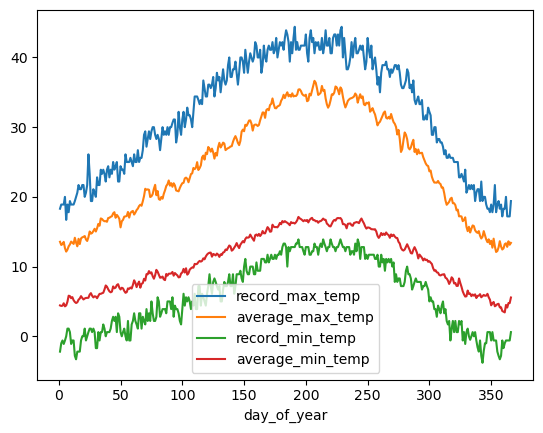

In [6]:
# First saving results to a dataframe and doing quick plot to see how things look

sac_stats = station_temp(stnid)
sac_stats.plot()

In [7]:
# I need to pull in actual temp for my year of choice (2020)

# Read in the same dataset from GHCN for our chosen station
df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/by_station/{stnid}.csv",
    storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
    dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
    parse_dates=['DATE']
    ).set_index('DATE')
# Need to ensure the date column is saved as a datetime data type and set as the index
df['DATE'] = pd.to_datetime(df.index)
# Adding a column for day of year, so that later I can group by this value
df['day_of_year'] = pd.to_datetime(df['DATE']).dt.dayofyear

# Here I am subsetting the dataset to only include 2020
df_2020 = df[(df.index >= pd.to_datetime('2020-01-01')) & (df.index <= pd.to_datetime('2020-12-31'))] 
df_2020 = df_2020.set_index('day_of_year')
print(df_2020)


                      ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME  \
day_of_year                                                                   
1            USW00023271    TMAX         161    NaN    NaN      W    2400.0   
2            USW00023271    TMAX         167    NaN    NaN      W    2400.0   
3            USW00023271    TMAX         167    NaN    NaN      W    2400.0   
4            USW00023271    TMAX         150    NaN    NaN      W    2400.0   
5            USW00023271    TMAX         150    NaN    NaN      W    2400.0   
...                  ...     ...         ...    ...    ...    ...       ...   
362          USW00023271    SNWD           0    NaN    NaN      W       NaN   
363          USW00023271    SNWD           0    NaN    NaN      W       NaN   
364          USW00023271    SNWD           0    NaN    NaN      W       NaN   
365          USW00023271    SNWD           0    NaN    NaN      W       NaN   
366          USW00023271    SNWD           0    NaN 

/tmp/ipykernel_935/3914101192.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"s3://noaa-ghcn-pds/csv/by_station/{stnid}.csv",


In [8]:
# Next taking another subset of the dataset to hold only TMAX values, and correcting units to be degrees C
df_2020_tmax = df_2020.loc[df_2020['ELEMENT'] == 'TMAX'].copy()
df_2020_tmax['2020_max'] = df_2020_tmax['DATA_VALUE'] / 10
df_2020_tmax = df_2020_tmax['2020_max']
print(df_2020_tmax)


day_of_year
1      16.1
2      16.7
3      16.7
4      15.0
5      15.0
       ... 
362    14.4
363    13.3
364    15.6
365    15.0
366    15.0
Name: 2020_max, Length: 366, dtype: float64


In [9]:
df_2020_tmin = df_2020.loc[df_2020['ELEMENT'] == 'TMIN'].copy()
df_2020_tmin['2020_min'] = df_2020_tmin['DATA_VALUE'] / 10
df_2020_tmin = df_2020_tmin['2020_min']
print(df_2020_tmin)

day_of_year
1      6.7
2      5.6
3      5.0
4      6.1
5      4.4
      ... 
362    5.0
363    6.1
364    2.8
365    2.8
366    6.1
Name: 2020_min, Length: 366, dtype: float64


In [10]:
actual_2020 = pd.merge(df_2020_tmax, df_2020_tmin, on='day_of_year')
print(actual_2020)

             2020_max  2020_min
day_of_year                    
1                16.1       6.7
2                16.7       5.6
3                16.7       5.0
4                15.0       6.1
5                15.0       4.4
...               ...       ...
362              14.4       5.0
363              13.3       6.1
364              15.6       2.8
365              15.0       2.8
366              15.0       6.1

[366 rows x 2 columns]


In [11]:
df_plot = pd.merge(actual_2020, sac_stats, on='day_of_year')
print(df_plot)

             2020_max  2020_min  record_max_temp  average_max_temp  \
day_of_year                                                          
1                16.1       6.7             18.3         13.556667   
2                16.7       5.6             18.9         13.093333   
3                16.7       5.0             18.9         13.226667   
4                15.0       6.1             18.9         13.543333   
5                15.0       4.4             20.0         12.650000   
...               ...       ...              ...               ...   
362              14.4       5.0             20.0         13.346667   
363              13.3       6.1             17.2         12.830000   
364              15.6       2.8             17.2         13.626667   
365              15.0       2.8             17.2         13.130000   
366              15.0       6.1             19.4         13.400000   

             record_min_temp  average_min_temp  
day_of_year                             

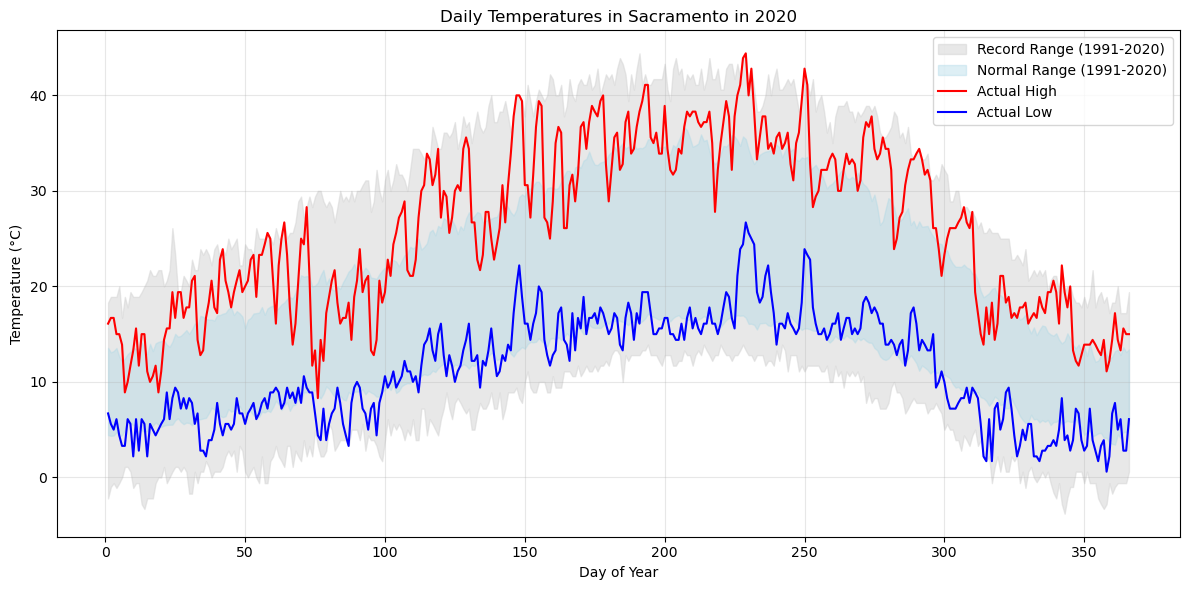

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Shaded area between record highs and lows
plt.fill_between(
    df_plot.index,
    df_plot['record_min_temp'],
    df_plot['record_max_temp'],
    color='lightgray',
    alpha=0.5,
    label='Record Range (1991-2020)'
)

# Shaded area between average highs and lows
plt.fill_between(
    df_plot.index,
    df_plot['average_min_temp'],
    df_plot['average_max_temp'],
    color='lightblue',
    alpha=0.4,
    label='Normal Range (1991-2020)'
)

# Actual daily highs and lows
plt.plot(df_plot['2020_max'], color='red', label='Actual High')
plt.plot(df_plot['2020_min'], color='blue', label='Actual Low')

plt.title("Daily Temperatures in Sacramento in 2020")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()